<a href="https://colab.research.google.com/github/buoi/conditional-face-GAN/blob/main/GAN_Attribute_Classifiers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [ ]:
_, gpu_name  = !nvidia-smi --query-gpu=gpu_name --format=csv

if gpu_name == 'Tesla T4':
    from tensorflow.keras import mixed_precision

    print("good gpu")
    policy = mixed_precision.Policy('mixed_float16')
    mixed_precision.set_global_policy(policy)

!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-a6024aa7-282e-30d8-b467-6d6c7b97c5f9)


In [ ]:
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.applications.inception_v3 import InceptionV3, preprocess_input
import tensorflow.keras.backend as K

import os
import gdown
from zipfile import ZipFile #chose this or !unzip

from tqdm.notebook import tqdm
from time import time
import pandas as pd
import random
import math

## Download CelebA data

We'll use face images from the CelebA dataset, resized to 64x64.

In [ ]:
try:
    os.makedirs("celeba_gan")
    url = "https://drive.google.com/uc?id=1O7m1010EJjLE5QxLZiM9Fpjs7Oj6e684"
    output = "celeba_gan/img_align_celeba.zip"
    gdown.download(url, output, quiet=True)

    with ZipFile("celeba_gan/img_align_celeba.zip", "r") as zipobj:
        zipobj.extractall("celeba_gan")
        
except FileExistsError:
    print("Dataset Already downloaded")

#Download labels from public github, they ahve been processed in a 0,1 csv file
!wget -q -O "/content/celeba_gan/list_attr_celeba01.csv.zip" "https://github.com/buoi/conditional-face-GAN/blob/main/list_attr_celeba01.csv.zip?raw=true" 
!unzip -o "/content/celeba_gan/list_attr_celeba01.csv.zip" -d "/content/celeba_gan"

Dataset Already downloaded
Archive:  /content/celeba_gan/list_attr_celeba01.csv.zip
  inflating: /content/celeba_gan/list_attr_celeba01.csv  
  inflating: /content/celeba_gan/__MACOSX/._list_attr_celeba01.csv  


In [ ]:


def f1_metric_logits(y_true, y_pred):
    y_pred = K.round(keras.activations.sigmoid(y_pred))
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)


def f1_metric(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)


def weighted_bce_from_logits(y_true, y_pred):

    #inverted_frequency weighting
    pos_weight= (1-attribute_frequency)*2
    y_true = tf.cast(y_true,'float32')
    bce = tf.nn.weighted_cross_entropy_with_logits(y_true, y_pred, pos_weight=pos_weight)
    #weighted_bce = attribute_frequency*(1-y_true) *bce
    #print(bce, weighted_bce)
    return K.mean(bce,axis=-1)


In [ ]:
# image utils functions

def conv_range(in_range=(-1,1), out_range=(0,255)):
    """ Returns range conversion function"""

    # compute means and spans once
    in_mean, out_mean = np.mean(in_range), np.mean(out_range)
    in_span, out_span = np.ptp(in_range), np.ptp(out_range)

    # return function
    def convert_img_range(in_img):
        out_img = (in_img - in_mean) / in_span
        out_img = out_img * out_span + out_mean
        return out_img

    return convert_img_range


def crop128(img):
    #return img[:, 77:141, 57:121]# 64,64 center crop
    return img[:, 45:173, 25:153] # 128,128 center crop


def resize64(img):
    return tf.image.resize(img, (64,64), antialias=True)

# Train 64x64 Attribute Classifier

Found 202599 files belonging to 2 classes.
Using 182340 files for training.
Found 202599 files belonging to 2 classes.
Using 20259 files for validation.
image in range:  -1.0 1.0000004


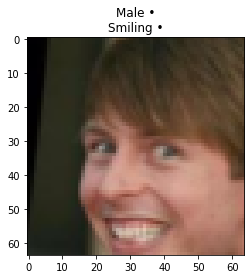

In [ ]:
#@title Build Dataset {form-width: "35%", display-mode: "both" }
NUMBER_OF_ATTRIBUTES = "2" #@param [0, 2, 10, 12, 40]
N_ATTRIBUTES = int(NUMBER_OF_ATTRIBUTES)

IMAGE_RANGE = '11'

BATCH_SIZE =  64#@param {type: "number"}
if N_ATTRIBUTES == 2:
    LABELS = ["Male", "Smiling"]

elif N_ATTRIBUTES == 10:
    LABELS = [
          "Mouth_Slightly_Open", "Wearing_Lipstick", "High_Cheekbones", "Male", "Smiling", 
          "Heavy_Makeup", "Wavy_Hair", "Oval_Face", "Pointy_Nose", "Arched_Eyebrows"]

elif N_ATTRIBUTES == 12:
    LABELS = ['Wearing_Lipstick','Mouth_Slightly_Open','Male','Smiling',
              'High_Cheekbones','Heavy_Makeup','Attractive','Young',
              'No_Beard','Black_Hair','Arched_Eyebrows','Big_Nose']
elif N_ATTRIBUTES == 40:
    LABELS = [
            '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive',
            'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose',
            'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows',
            'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair',
            'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open',
            'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin',
            'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns',
            'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings',
            'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace',
            'Wearing_Necktie', 'Young']

else:
    LABELS = ["Male", "Smiling"]# just for dataset creation
 

# Take labels and a list of image locations in memory
df = pd.read_csv(r"/content/celeba_gan/list_attr_celeba01.csv")
im_list = df['image_id'].tolist()


# load image at exact resolution
dataset_train = keras.preprocessing.image_dataset_from_directory(
    "celeba_gan", label_mode="int", 
    labels = df[LABELS].values.tolist(),
    image_size=(218, 178), 
    batch_size=BATCH_SIZE,
    validation_split=0.1, subset='training',seed=11)

dataset_val = keras.preprocessing.image_dataset_from_directory(
    "celeba_gan", label_mode="int", 
    labels = df[LABELS].values.tolist(),
    image_size=(218, 178), 
    batch_size=BATCH_SIZE,
    validation_split=0.1, subset='validation',seed=11)

dataset_train.shuffle(200000)
dataset_val.shuffle(30000)
FID_COUNT = 10000
val_batch_size = 200
assert FID_COUNT%val_batch_size ==0
val_batch_n = FID_COUNT//val_batch_size

#rebatch to divisor of 10000
dataset_val = dataset_val.unbatch().batch(val_batch_size)
#take 10000 samples, 100 batches 

def preprocess(dataset):
    # extract the center crop
    dataset = dataset.map(lambda x,y: (crop128(x),y) )
    # resize
    dataset = dataset.map(lambda x,y: (resize64(x),y) )
    # convert image range
    dataset = dataset.map(lambda x,y: (conv_range([0,255], [-1,1])(x),y) )
    
    return dataset

dataset_train = preprocess(dataset_train)
dataset_val = preprocess(dataset_val)

if N_ATTRIBUTES !=0: 

    batch_img, batch_labels = next(iter(dataset_train))
    plt.title('\n'.join([(1-label)*'Not_'+LABELS[i]+' •'*int(label) for i,label in enumerate(batch_labels[0])]))

else: # remove labels
    dataset_train = dataset_train.map(lambda x,y: x)
    dataset_val = dataset_val.map(lambda x,y: x)
    batch_img = next(iter(dataset_train))
    
plt.imshow(batch_img[0].numpy()/2+0.5)

print("image in range: ", np.min(batch_img), np.max(batch_img))

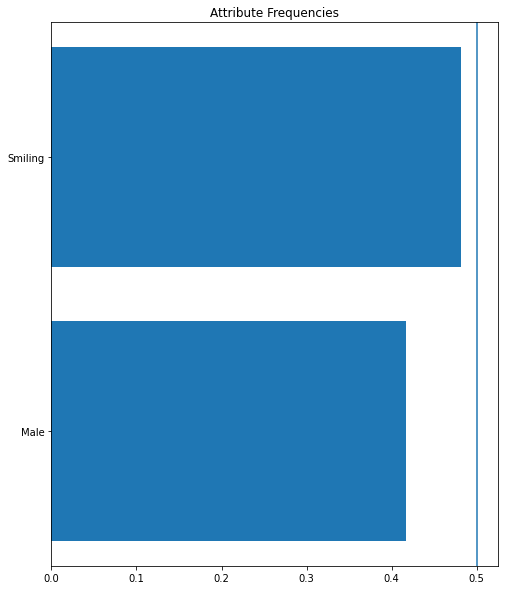

In [ ]:
attribute_cumsums = np.sum(df[LABELS].values, axis=0)

attribute_frequency = attribute_cumsums/df[LABELS].values.shape[0]
# shows how much each attribute deviates from being 50%
freq_sorted, labels_sorted  = zip(*sorted(zip(attribute_frequency, LABELS)))
freq_sorted = np.array(freq_sorted)

plt.figure(figsize=(8,10))
plt.title("Attribute Frequencies")
plt.yticks(np.arange(N_ATTRIBUTES),labels=labels_sorted, fontsize=10)
plt.axvline(x=0.5)
plt.barh(np.arange(N_ATTRIBUTES), freq_sorted);

In [ ]:
ENABLE_WANDB = True #@param {type:"boolean"}
WANDB_RESUME = False #@param {type:"boolean"}

resume_id = "" #@param {type: "string"}
WANDB_RESUME = (resume_id if WANDB_RESUME else False)

project_name = "GAN" #@param {type: "string"}
model_name = "mobilenet_2attr_weighted" #@param {type: "string"}
experiment_name = "mobilenet_2attr_weighted" #@param {type: "string"}

assert '-' not in model_name
assert ' ' not in model_name

if ENABLE_WANDB:
    !pip install wandb > /dev/null
    !wandb login
    import wandb
    from wandb.keras import WandbCallback
    run = wandb.init(project=project_name, 
                     name=experiment_name, 
                     resume=WANDB_RESUME)
    

wandb: Currently logged in as: buio (use `wandb login --relogin` to force relogin)


binary_accuracy,▁▂▂▂▃▃▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇█████████
f1_metric_logits,▁▃▄▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████████████
loss,█▅▅▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
binary_accuracy,0.71092
f1_metric_logits,0.69284
loss,0.55236


In [ ]:
from wandb.keras import WandbCallback

In [ ]:
SHAPE =(64,64,3)

feature_extractor = tf.keras.applications.MobileNetV2(
    include_top=False,
    weights="imagenet",
    input_shape = SHAPE,
    pooling='avg'
)
# do just transfer learning
feature_extractor.trainable = False

img_in = layers.Input(shape = SHAPE, name='img_input')
#img_up = tf.image.resize(img_in, (128, 128), method='bilinear', antialias=True, name='upsample_BILINEAR')
img_repr = feature_extractor(img_in)
img_repr = tf.keras.layers.Flatten()(img_repr)

classifier = layers.Dense(N_ATTRIBUTES, activation='linear', 
                          name='classifier')(img_repr)
                          
attr_class = keras.Model(inputs=[img_in], outputs=[classifier])

optim = keras.optimizers.Adam(learning_rate=0.0002)
attr_class.compile(optim, weighted_bce_from_logits, 
                   metrics = ['binary_accuracy', f1_metric_logits] )
es_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=2,
    mode="auto",
)

attr_class.summary()

attr_class.fit(dataset_train, validation_data=dataset_val, epochs=10, 
               callbacks =[es_callback, WandbCallback(log_batch_frequency=10, verbose=1)])

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img_input (InputLayer)       [(None, 64, 64, 3)]       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 1280)              2257984   
_________________________________________________________________
flatten_2 (Flatten)          (None, 1280)              0         
_________________________________________________________________
classifier (Dense)           (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________
Epoch 1/10
2850/2850 [==============================] - 246s 85ms/step - loss: 0.4647 - binary_accuracy: 0.7754 - f1_metric_logits: 0.7643 - val_loss: 0.4246 - val_binary_accuracy: 0.7993 - val_f1_metric_logits: 0.7908
Epoch 00000: val_loss im

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/10
2850/2850 [==============================] - 240s 84ms/step - loss: 0.4165 - binary_accuracy: 0.8063 - f1_metric_logits: 0.7951 - val_loss: 0.4118 - val_binary_accuracy: 0.8129 - val_f1_metric_logits: 0.8029
Epoch 00001: val_loss improved from 0.42461 to 0.41182, saving model to /content/wandb/run-20211020_215858-2ckbukxu/files/model-best.h5
Epoch 3/10
2850/2850 [==============================] - 259s 91ms/step - loss: 0.4068 - binary_accuracy: 0.8117 - f1_metric_logits: 0.8005 - val_loss: 0.4071 - val_binary_accuracy: 0.8164 - val_f1_metric_logits: 0.8051
Epoch 00002: val_loss improved from 0.41182 to 0.40710, saving model to /content/wandb/run-20211020_215858-2ckbukxu/files/model-best.h5
Epoch 4/10
2850/2850 [==============================] - 260s 91ms/step - loss: 0.4026 - binary_accuracy: 0.8145 - f1_metric_logits: 0.8023 - val_loss: 0.4043 - val_binary_accuracy: 0.8167 - val_f1_metric_logits: 0.8039
Epoch 00003: val_loss improved from 0.40710 to 0.40426, saving model to

In [ ]:
# fine tuning of entire network with 1/10 lr
for layer in attr_class.layers:
    layer.trainable = True

es_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=1,
    mode="auto",
)
attr_class.summary()

#keep same optimizer with modified LR
optim.learning_rate = 0.00002
attr_class.compile(optim, 
                   weighted_bce_from_logits, 
                   metrics = ['binary_accuracy', f1_metric_logits] )

attr_class.fit(dataset_train, validation_data=dataset_val, epochs=10, 
               callbacks = [es_callback, WandbCallback(log_batch_frequency=10, verbose=1)])

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img_input (InputLayer)       [(None, 64, 64, 3)]       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 1280)              2257984   
_________________________________________________________________
flatten_2 (Flatten)          (None, 1280)              0         
_________________________________________________________________
classifier (Dense)           (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,226,434
Non-trainable params: 34,112
_________________________________________________________________
Epoch 1/10
2850/2850 [==============================] - 284s 97ms/step - loss: 0.3298 - binary_accuracy: 0.8578 - f1_metric_logits: 0.8455 - val_loss: 0.2417 - val_binary_accuracy: 0.9096 - val_f1_metric_logits: 0.8994
Epoch 00000: val_loss i

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/10
2850/2850 [==============================] - 295s 103ms/step - loss: 0.2093 - binary_accuracy: 0.9141 - f1_metric_logits: 0.9072 - val_loss: 0.1800 - val_binary_accuracy: 0.9289 - val_f1_metric_logits: 0.9221
Epoch 00001: val_loss improved from 0.24168 to 0.18004, saving model to /content/wandb/run-20211020_215858-2ckbukxu/files/model-best.h5
Epoch 3/10
2850/2850 [==============================] - 280s 98ms/step - loss: 0.1721 - binary_accuracy: 0.9302 - f1_metric_logits: 0.9247 - val_loss: 0.1592 - val_binary_accuracy: 0.9360 - val_f1_metric_logits: 0.9300
Epoch 00002: val_loss improved from 0.18004 to 0.15922, saving model to /content/wandb/run-20211020_215858-2ckbukxu/files/model-best.h5
Epoch 4/10
2850/2850 [==============================] - 298s 104ms/step - loss: 0.1482 - binary_accuracy: 0.9399 - f1_metric_logits: 0.9352 - val_loss: 0.1586 - val_binary_accuracy: 0.9364 - val_f1_metric_logits: 0.9316
Epoch 00003: val_loss improved from 0.15922 to 0.15862, saving model 

In [ ]:
SAVE_PATH = 'models/'
os.makedirs(SAVE_PATH, exist_ok=True)

attr_class.save(SAVE_PATH + model_name, save_format='tf')
artifact = wandb.Artifact(model_name, type='model')
artifact.add_dir(SAVE_PATH)
run.log_artifact(artifact)

INFO:tensorflow:Assets written to: models/mobilenet_2attr_weighted/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
wandb: Adding directory to artifact (./models)... Done. 0.5s


In [ ]:
run.finish()

binary_accuracy,▁▂▂▃▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▃▅▆▇▇▇▇▇▇███████
epoch,▁▂▃▃▄▅▆▆▇█▁▂▃▃▄▅▆
f1_metric_logits,▁▂▃▃▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▃▄▆▇▇▇▇▇▇███████
loss,█▇▇▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▅▃▃▂▂▂▂▂▂▁▁▁▁▁▁
val_binary_accuracy,▁▂▂▂▂▂▂▂▂▂▆▇█████
val_f1_metric_logits,▁▂▂▂▂▂▂▂▂▂▆▇█████
val_loss,███▇▇▇▇▇▇▇▃▂▁▁▁▁▁
best_epoch,5
best_val_loss,0.145
binary_accuracy,0.9577
epoch,6


# Train 218x178 Attribute Classifier

Found 202599 files belonging to 2 classes.
Using 182340 files for training.
Found 202599 files belonging to 2 classes.
Using 20259 files for validation.
image in range:  -1.0 1.0


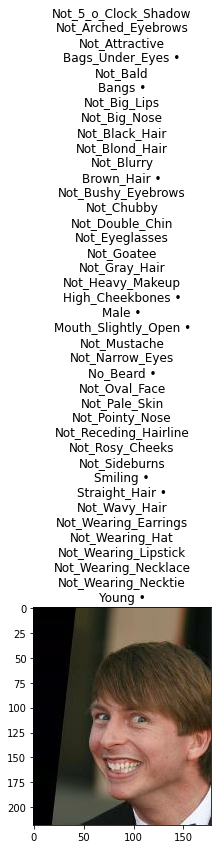

In [ ]:
#@title Build Dataset {form-width: "35%", display-mode: "both" }
NUMBER_OF_ATTRIBUTES = "40" #@param [0, 2, 10, 12, 40]
N_ATTRIBUTES = int(NUMBER_OF_ATTRIBUTES)

IMAGE_RANGE = '11'

BATCH_SIZE =  64#@param {type: "number"}
if N_ATTRIBUTES == 2:
    LABELS = ["Male", "Smiling"]

elif N_ATTRIBUTES == 10:
    LABELS = [
          "Mouth_Slightly_Open", "Wearing_Lipstick", "High_Cheekbones", "Male", "Smiling", 
          "Heavy_Makeup", "Wavy_Hair", "Oval_Face", "Pointy_Nose", "Arched_Eyebrows"]

elif N_ATTRIBUTES == 12:
    LABELS = ['Wearing_Lipstick','Mouth_Slightly_Open','Male','Smiling',
              'High_Cheekbones','Heavy_Makeup','Attractive','Young',
              'No_Beard','Black_Hair','Arched_Eyebrows','Big_Nose']
elif N_ATTRIBUTES == 40:
    LABELS = [
            '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive',
            'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose',
            'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows',
            'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair',
            'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open',
            'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin',
            'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns',
            'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings',
            'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace',
            'Wearing_Necktie', 'Young']

else:
    LABELS = ["Male", "Smiling"]# just for dataset creation
 

# Take labels and a list of image locations in memory
df = pd.read_csv(r"/content/celeba_gan/list_attr_celeba01.csv")
im_list = df['image_id'].tolist()


# load image at exact resolution
dataset_train = keras.preprocessing.image_dataset_from_directory(
    "celeba_gan", label_mode="int", 
    labels = df[LABELS].values.tolist(),
    image_size=(218, 178), 
    batch_size=BATCH_SIZE,
    validation_split=0.1, subset='training',seed=11)

dataset_val = keras.preprocessing.image_dataset_from_directory(
    "celeba_gan", label_mode="int", 
    labels = df[LABELS].values.tolist(),
    image_size=(218, 178), 
    batch_size=BATCH_SIZE,
    validation_split=0.1, subset='validation',seed=11)

dataset_train.shuffle(200000)
dataset_val.shuffle(30000)
FID_COUNT = 10000
val_batch_size = 200
assert FID_COUNT%val_batch_size ==0
val_batch_n = FID_COUNT//val_batch_size

#rebatch to divisor of 10000
dataset_val = dataset_val.unbatch().batch(val_batch_size)
#take 10000 samples, 100 batches 

def preprocess(dataset):
    # extract the center crop
    #dataset = dataset.map(lambda x,y: (crop128(x),y) )
    # resize
    # dataset = dataset.map(lambda x,y: (resize64(x),y) )
    # convert image range
    dataset = dataset.map(lambda x,y: (conv_range([0,255], [-1,1])(x),y) )
    
    return dataset

dataset_train = preprocess(dataset_train)
dataset_val = preprocess(dataset_val)

if N_ATTRIBUTES !=0: 

    batch_img, batch_labels = next(iter(dataset_train))
    plt.title('\n'.join([(1-label)*'Not_'+LABELS[i]+' •'*int(label) for i,label in enumerate(batch_labels[0])]))

else: # remove labels
    dataset_train = dataset_train.map(lambda x,y: x)
    dataset_val = dataset_val.map(lambda x,y: x)
    batch_img = next(iter(dataset_train))
    
plt.imshow(batch_img[0].numpy()/2+0.5)

print("image in range: ", np.min(batch_img), np.max(batch_img))

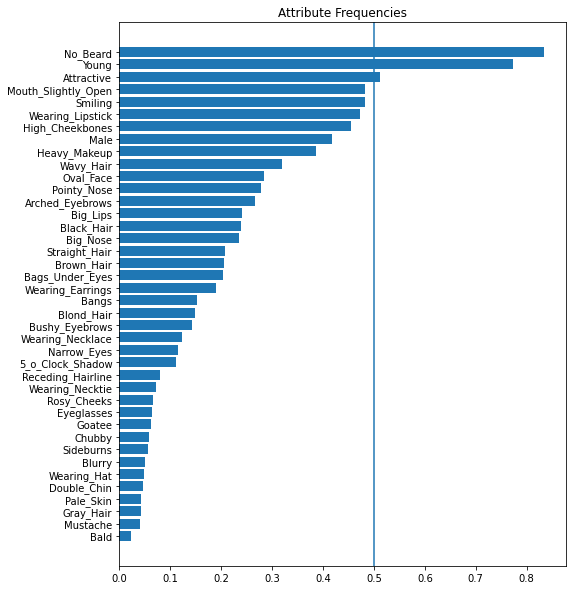

In [ ]:
attribute_cumsums = np.sum(df[LABELS].values, axis=0)

attribute_frequency = attribute_cumsums/df[LABELS].values.shape[0]
# shows how much each attribute deviates from being 50%
freq_sorted, labels_sorted  = zip(*sorted(zip(attribute_frequency, LABELS)))
freq_sorted = np.array(freq_sorted)

plt.figure(figsize=(8,10))
plt.title("Attribute Frequencies")
plt.yticks(np.arange(N_ATTRIBUTES),labels=labels_sorted, fontsize=10)
plt.axvline(x=0.5)
plt.barh(np.arange(N_ATTRIBUTES), freq_sorted);

In [ ]:
feature_extractor = tf.keras.applications.MobileNetV2(
    include_top=False,
    weights="imagenet",
    input_shape = (224,224,3),
    pooling='avg'
)

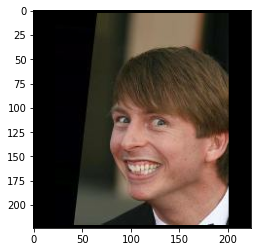

In [ ]:
input_shape = (218,178,3)
target_shape= (224,224,3)

h,w,_ = input_shape

halfh = (target_shape[0]-h)/2
halfw = (target_shape[1]-w)/2

padup, paddown = int(np.ceil(halfh)), int(np.floor(halfh))
padleft, padright = int(np.ceil(halfw)), int(np.floor(halfw))

img_up = tf.pad(batch_img, [[0,0],[padup,paddown],[padleft,padright],[0,0]],constant_values=-1)
plt.imshow(img_up[0]*0.5+0.5)


In [ ]:
ENABLE_WANDB = True #@param {type:"boolean"}
WANDB_RESUME = False #@param {type:"boolean"}

resume_id = "" #@param {type: "string"}
WANDB_RESUME = (resume_id if WANDB_RESUME else False)

project_name = "GAN" #@param {type: "string"}
model_name = "mobilenet_40attr_218x178_weighted" #@param {type: "string"}
experiment_name = "mobilenet_40attr_218x178_weighted" #@param {type: "string"}

assert '-' not in model_name
assert ' ' not in model_name

if ENABLE_WANDB:
    !pip install wandb > /dev/null
    !wandb login
    import wandb
    from wandb.keras import WandbCallback
    run = wandb.init(project=project_name, 
                     name=experiment_name, 
                     resume=WANDB_RESUME)
    

wandb: Currently logged in as: buio (use `wandb login --relogin` to force relogin)


wandb: Currently logged in as: buio (use `wandb login --relogin` to force relogin)


In [ ]:
from wandb.keras import WandbCallback

In [18]:
SHAPE =(218,178,3)
# do just transfer learning
feature_extractor.trainable = False

img_in = layers.Input(shape=SHAPE, name='img_input')

#img_up = tf.image.resize(img_in, (229, 229), method='bilinear', antialias=True, name='upsample_BILINEAR')
#img_up = tf.image.resize(img_in, (128, 128), method='bilinear', antialias=True, name='upsample_BILINEAR')
#img_up = tf.pad(img_in, [[0,0],[padup,paddown],[padleft,padright],[0,0]],constant_values=-1)
img_up = tf.keras.layers.ZeroPadding2D([(padup,paddown),(padleft,padright)])(img_in)

img_repr = feature_extractor(img_up)
img_repr = tf.keras.layers.Flatten()(img_repr)
classifier = layers.Dense(N_ATTRIBUTES, activation='linear', name='classifier')(img_repr)
attr_class = keras.Model(inputs=[img_in], outputs=[classifier])

optim = keras.optimizers.Adam(learning_rate=0.0002)
attr_class.compile(optim, weighted_bce_from_logits, metrics = ['binary_accuracy', f1_metric_logits] )

es_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=2,
    mode="auto",
)

attr_class.summary()
attr_class.fit(dataset_train, validation_data=dataset_val, epochs=10, callbacks =[es_callback, WandbCallback(log_batch_frequency=10, verbose=1)])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img_input (InputLayer)       [(None, 218, 178, 3)]     0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 1280)              2257984   
_________________________________________________________________
flatten (Flatten)            (None, 1280)              0         
_________________________________________________________________
classifier (Dense)           (None, 40)                51240     
Total params: 2,309,224
Trainable params: 51,240
Non-trainable params: 2,257,984
_________________________________________________________________
Epoch 1/10
2850/2850 [==============================] - 264s 91ms/step - loss: 0.3783 - binary_accuracy: 0.8583 

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/10
2850/2850 [==============================] - 239s 84ms/step - loss: 0.3431 - binary_accuracy: 0.8711 - f1_metric_logits: 0.5501 - val_loss: 0.3400 - val_binary_accuracy: 0.8722 - val_f1_metric_logits: 0.5785
Epoch 00001: val_loss improved from 0.35045 to 0.33995, saving model to /content/wandb/run-20211021_102024-zd9xh3kq/files/model-best.h5
Epoch 3/10
2850/2850 [==============================] - 236s 83ms/step - loss: 0.3358 - binary_accuracy: 0.8739 - f1_metric_logits: 0.5652 - val_loss: 0.3356 - val_binary_accuracy: 0.8737 - val_f1_metric_logits: 0.5885
Epoch 00002: val_loss improved from 0.33995 to 0.33559, saving model to /content/wandb/run-20211021_102024-zd9xh3kq/files/model-best.h5
Epoch 4/10
2850/2850 [==============================] - 237s 83ms/step - loss: 0.3319 - binary_accuracy: 0.8754 - f1_metric_logits: 0.5728 - val_loss: 0.3331 - val_binary_accuracy: 0.8747 - val_f1_metric_logits: 0.5946
Epoch 00003: val_loss improved from 0.33559 to 0.33311, saving model to

In [19]:
# fine tuning of entire network with 1/10 lr
for layer in attr_class.layers:
    layer.trainable = True

es_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=1,
    mode="auto",
)

attr_class.summary()

optim.learning_rate = 0.00002

attr_class.compile(optim, 
                   weighted_bce_from_logits, 
                   metrics = ['binary_accuracy', f1_metric_logits] )

attr_class.fit(dataset_train, validation_data=dataset_val, epochs=10, 
               callbacks = [es_callback, WandbCallback(log_batch_frequency=10, verbose=1)])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img_input (InputLayer)       [(None, 218, 178, 3)]     0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 1280)              2257984   
_________________________________________________________________
flatten (Flatten)            (None, 1280)              0         
_________________________________________________________________
classifier (Dense)           (None, 40)                51240     
Total params: 2,309,224
Trainable params: 2,275,112
Non-trainable params: 34,112
_________________________________________________________________
Epoch 1/10
2850/2850 [==============================] - 959s 334ms/step - loss: 0.2768 - binary_accuracy: 0.8982

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/10
2850/2850 [==============================] - 930s 326ms/step - loss: 0.2458 - binary_accuracy: 0.9094 - f1_metric_logits: 0.6993 - val_loss: 0.2422 - val_binary_accuracy: 0.9113 - val_f1_metric_logits: 0.7215
Epoch 00001: val_loss improved from 0.25607 to 0.24219, saving model to /content/wandb/run-20211021_102024-zd9xh3kq/files/model-best.h5
Epoch 3/10
2850/2850 [==============================] - 932s 327ms/step - loss: 0.2352 - binary_accuracy: 0.9133 - f1_metric_logits: 0.7148 - val_loss: 0.2364 - val_binary_accuracy: 0.9132 - val_f1_metric_logits: 0.7283
Epoch 00002: val_loss improved from 0.24219 to 0.23638, saving model to /content/wandb/run-20211021_102024-zd9xh3kq/files/model-best.h5
Epoch 4/10
2850/2850 [==============================] - 933s 327ms/step - loss: 0.2282 - binary_accuracy: 0.9158 - f1_metric_logits: 0.7251 - val_loss: 0.2334 - val_binary_accuracy: 0.9141 - val_f1_metric_logits: 0.7320
Epoch 00003: val_loss improved from 0.23638 to 0.23342, saving model

In [ ]:
SAVE_PATH = 'models/'
os.makedirs(SAVE_PATH, exist_ok=True)

attr_class.save(SAVE_PATH + model_name, save_format='tf')
artifact = wandb.Artifact(model_name, type='model')
artifact.add_dir(SAVE_PATH)
run.log_artifact(artifact)

In [21]:
run.finish()

binary_accuracy,▁▂▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▆▆▇▇▇▇▇▇█████████
epoch,▁▂▃▃▄▅▆▆▇█▁▂▃▃▄▅▆▆
f1_metric_logits,▁▃▄▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇██████████
loss,█▇▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
val_binary_accuracy,▁▂▂▂▂▂▂▂▂▂▇▇██████
val_f1_metric_logits,▁▂▂▃▃▃▃▃▃▃▇▇██████
val_loss,█▇▇▇▇▇▇▇▇▇▃▂▁▁▁▁▁▁
best_epoch,6
best_val_loss,0.23029
binary_accuracy,0.92228
epoch,7


# Load Trained Classifier

In [ ]:
#@title Load Multilabel Classifier Model{form-width: "30%", display-mode: "both" }

#refactor to attribute accuracy logger
ENABLE_LOAD = True #@param {type:"boolean"}

if N_ATTRIBUTES == 2:
    resume_id = "2hxg7lvr"
    model_name = experiment_name = "mobilenet_2attr"
elif N_ATTRIBUTES == 10:
    resume_id = "3pxaxlw4"
    model_name = experiment_name = "mobilenet_10attr"
elif N_ATTRIBUTES == 40:
    resume_id = "joo3ui3c"
    model_name = experiment_name = "mobilenet_40attr"

else:
    print("N_ATTRIBUTES=", N_ATTRIBUTES, "skipping classifier load")
    ENABLE_LOAD = False

print("Using:",N_ATTRIBUTES,"attributes")

if ENABLE_LOAD:
    WANDB_MODE='online'
    project_name = "GAN"
    !pip install wandb > /dev/null
    !wandb online
    import wandb
    from wandb.keras import WandbCallback
    run = wandb.init(project=project_name, 
                     name=experiment_name, 
                     id=resume_id, resume=True)

    run_name = 'buio/GAN/'+ model_name
    artifact_run = run_name +':latest'

    artifact = run.use_artifact(artifact_run, type='model')
    artifact_dir = artifact.download()
    attribute_classifier = tf.keras.models.load_model(os.path.join(artifact_dir, model_name))

    attribute_classifier.compile(loss=keras.losses.BinaryCrossentropy(), metrics='binary_accuracy')
    #loss, gen_attr_accuracy = attribute_classifier.evaluate(dataset_df)
    #gen_attr_accuracy

    run.finish()

In [ ]:
pred_attr = np.zeros((len(dataset_val)*BATCH_SIZE, N_ATTRIBUTES))
real_attr = np.zeros_like(pred_attr)

print(real_attr.shape)
for i,(batch_images, batch_attr) in tqdm(enumerate(dataset_val)):
    batch_len = len(batch_images)

    pred_attr[i*batch_len:(i+1)*batch_len] = attribute_classifier.predict(batch_images)
    real_attr[i*batch_len:(i+1)*batch_len] = batch_attr



In [ ]:
matches = np.zeros_like(pred_attr, dtype='int')
# discretize predictions
pred_attr[pred_attr>0.5] =1
pred_attr[pred_attr!=1] = 0

# compute accuracy: matches/total
matches[pred_attr == real_attr] = 1
matches.shape
total_matches = np.sum(matches, axis=0)

attribute_accuracy = total_matches/(len(dataset_val)*BATCH_SIZE)

# compute precision: true positives/ total retrieved positives: how valid
true_positives = pred_attr * matches
attribute_precision = np.sum(true_positives,axis=0) / np.sum(pred_attr,axis=0)

# compute recall: true positives/total positives : how complete
attribute_recall =  np.sum(true_positives,axis=0)/ np.sum(real_attr,axis=0)

attribute_f1_score = 2*attribute_precision*attribute_recall/(attribute_precision+attribute_recall)

# shows how much each attribute is well predicted
def barplot_metric(metric, title):

    metric_sorted, labels_sorted  = zip(*sorted(zip(metric, LABELS)))
    metric_sorted = np.array(acc_sorted)

    plt.figure(figsize=(8,10))
    plt.title(title)
    plt.yticks(np.arange(N_ATTRIBUTES),labels=labels_sorted, fontsize=10)
    plt.axvline(x=0.9)
    plt.barh(np.arange(N_ATTRIBUTES), metric_sorted);
    plt.show()
    return labels_sorted[:-11:-1]

aa = barplot_metric(attribute_accuracy, "Attribute Accuracy")
pp = barplot_metric(attribute_precision,"Attribute Precision")
rr = barplot_metric(attribute_recall, "Attribute Recall")
f1 = barplot_metric(attribute_f1_score, "Attribute F1-score")

aa = set(aa)
pp = set(pp)
rr = set(rr)

# Male, Eyeglasses